# Aligned/Lambdaclass zkVMs benchmarks

## Benchmarks of VM proving times made by Aligned and Lambdaclass

These benchmarks aim to provide a neutral suite for measuring the efficiency of zkVMs. 

You can run this Python notebook yourself to create new plots or analyze the data.

Raw results can be found [here](https://github.com/yetanotherco/zkvm_benchmarks/tree/main/bench_results).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
## Some auxiliary functions

def time_to_seconds(time_str):
    time_str = time_str.strip()
    try:
        if 'm' in time_str:
            parts = time_str.split('m')
            minutes = float(parts[0])
            seconds = 0
            if len(parts) > 1 and parts[1]:
                seconds = float(parts[1].replace('s', ''))
            return minutes * 60 + seconds
        else:
            return float(time_str.replace('s', ''))
    except Exception as e:
        print(f"Error parsing time: {time_str}")
        print(f"Error details: {e}")
        return None

## Fibonacci Benchmarks

In this section we will analyze the performance of Fibonacci for different provers.

The data was collected on a server with the following specs:
- CPU: AMD EPYC 8534P 64-Core Processor
- RAM: 576GB
- OS: Ubuntu 24 LTS

Data loaded from: `bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv`

### Load the data

In [4]:
input_csv_path = 'bench_results/fibo_5_mar_25_epyc8534p_64c_576gb.csv'

# Read data from CSV
df = pd.read_csv(input_csv_path)
df['N'] = df['N'].astype(int)

for idx, row in df.iterrows():
    seconds = time_to_seconds(row['Time'])

df['Seconds'] = df['Time'].apply(time_to_seconds)
df['Minutes'] = df['Seconds'] / 60

### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [5]:
# Print sorted data for validation
print("\nData sorted by Prover and N for validation:")
pd.set_option('display.float_format', '{:.2f}'.format)
validation_df = df.sort_values(['Prover', 'N'])[['Prover', 'N', 'Time', 'Minutes']]
print(validation_df.to_string())


Data sorted by Prover and N for validation:
                 Prover        N     Time  Minutes
0   Pico-AVX512 Groth16    10000    22.9s     0.38
4   Pico-AVX512 Groth16   100000    35.5s     0.59
8   Pico-AVX512 Groth16  1000000  1m46.0s     1.77
12  Pico-AVX512 Groth16  4000000  5m18.6s     5.31
3                 Risc0    10000    10.8s     0.18
7                 Risc0   100000    50.9s     0.85
11                Risc0  1000000  7m53.1s     7.89
15                Risc0  4000000  31m2.0s    31.03
1            SP1-AVX512    10000    16.0s     0.27
5            SP1-AVX512   100000    34.0s     0.57
9            SP1-AVX512  1000000  1m42.8s     1.71
13           SP1-AVX512  4000000  5m21.2s     5.35
2    SP1-AVX512-Groth16    10000  1m18.5s     1.31
6    SP1-AVX512-Groth16   100000  1m36.4s     1.61
10   SP1-AVX512-Groth16  1000000  2m45.8s     2.76
14   SP1-AVX512-Groth16  4000000  6m29.4s     6.49


### Data analytics

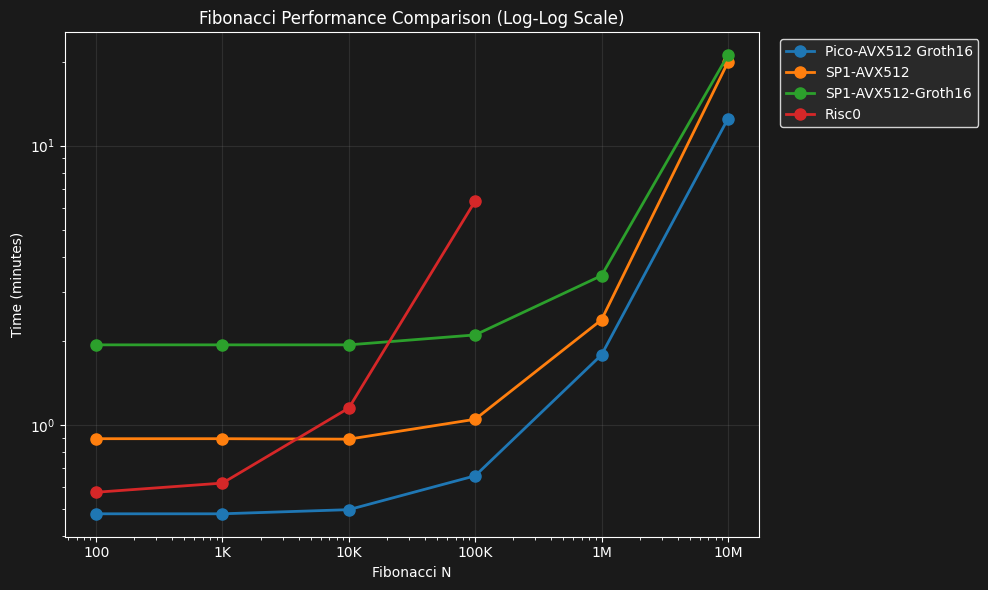

In [13]:
# Plot the data

# Set dark mode style
plt.style.use('dark_background')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create single figure with dark background
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')

# Function to plot data
def plot_data(ax, data):
    for i, prover in enumerate(data['Prover'].unique()):
        prover_data = data[data['Prover'] == prover].sort_values('N')
        # print(f"\nPlotting data for {prover}:")
        # print(prover_data[['N', 'Minutes']].to_string())

        ax.loglog(prover_data['N'], prover_data['Minutes'], 'o-',
                 label=prover, linewidth=2, markersize=8,
                 color=colors[i % len(colors)])

# Plot log-log scale
plot_data(ax, df)
ax.set_xlabel("Fibonacci N", color='white')
ax.set_ylabel('Time (minutes)', color='white')
ax.set_title(f'Fibonacci Performance Comparison (Log-Log Scale)', color='white')
ax.grid(True, alpha=0.2, color='gray')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
          frameon=True, facecolor='#2d2d2d', edgecolor='white',
          labelcolor='white')

# Set tick colors
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Format x-axis to show numbers in millions/thousands
def format_func(x, p):
    if x >= 1_000_000:
        millions = x / 1_000_000
        if millions.is_integer():
            return f'{int(millions)}M'
        else:
            return f'{millions:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    return str(int(x))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.tight_layout()

plt.show()

## Keccack Benchmarks

In this section we will analyze the performance of Keccak for different provers.

The data was collected on a server with the following specs:
- CPU: AMD EPYC 8534P 64-Core Processor
- RAM: 576GB
- OS: Ubuntu 24 LTS

Data loaded from: `bench_results/keccak_5_mar_25_epyc8534p_64c_576gb.csv`

### Load the data

In [7]:
input_csv_path = 'bench_results/keccak_5_mar_25_epyc8534p_64c_576gb.csv'

# Read data from CSV
df = pd.read_csv(input_csv_path)
df['N'] = df['N'].astype(int)

for idx, row in df.iterrows():
    seconds = time_to_seconds(row['Time'])

df['Seconds'] = df['Time'].apply(time_to_seconds)
df['Minutes'] = df['Seconds'] / 60

### Print the data sorted by Prover and N

For validation purposes, we will print the data sorted by Prover and N.

In [8]:
# Print sorted data for validation
print("\nData sorted by Prover and N for validation:")
pd.set_option('display.float_format', '{:.2f}'.format)
validation_df = df.sort_values(['Prover', 'N'])[['Prover', 'N', 'Time', 'Minutes']]
print(validation_df.to_string())


Data sorted by Prover and N for validation:
                 Prover         N      Time  Minutes
0   Pico-AVX512 Groth16       100     28.8s     0.48
3   Pico-AVX512 Groth16      1000     28.8s     0.48
6   Pico-AVX512 Groth16     10000     29.8s     0.50
9   Pico-AVX512 Groth16    100000     39.4s     0.66
12  Pico-AVX512 Groth16   1000000   1m46.8s     1.78
15  Pico-AVX512 Groth16  10000000  12m27.4s    12.46
18                Risc0       100     34.4s     0.57
19                Risc0      1000     37.1s     0.62
20                Risc0     10000    1m8.9s     1.15
21                Risc0    100000   6m19.7s     6.33
1            SP1-AVX512       100     53.5s     0.89
4            SP1-AVX512      1000     53.5s     0.89
7            SP1-AVX512     10000     53.3s     0.89
10           SP1-AVX512    100000    1m2.8s     1.05
13           SP1-AVX512   1000000   2m22.6s     2.38
16           SP1-AVX512  10000000  19m51.6s    19.86
2    SP1-AVX512-Groth16       100   1m56.0s     1.93
5

### Data analytics

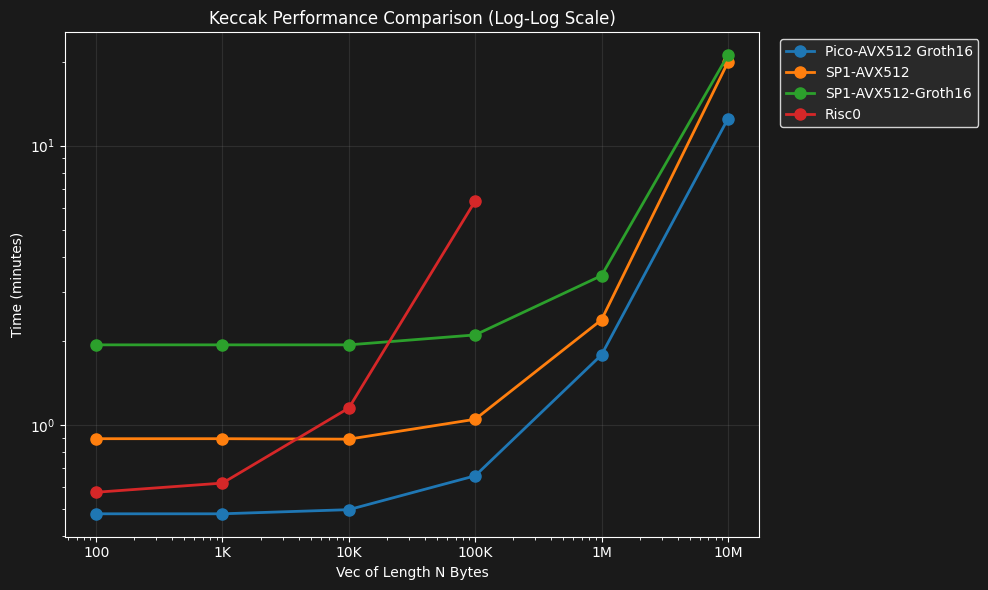

In [9]:
#Plot the data

# Set dark mode style
plt.style.use('dark_background')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Create single figure with dark background
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')


# Function to plot data
def plot_data(ax, data):
    for i, prover in enumerate(data['Prover'].unique()):
        prover_data = data[data['Prover'] == prover].sort_values('N')
        # print(f"\nPlotting data for {prover}:")
        # print(prover_data[['N', 'Minutes']].to_string())

        ax.loglog(prover_data['N'], prover_data['Minutes'], 'o-',
                 label=prover, linewidth=2, markersize=8,
                 color=colors[i % len(colors)])

# Plot log-log scale
plot_data(ax, df)
ax.set_xlabel('Vec of Length N Bytes', color='white')
ax.set_ylabel('Time (minutes)', color='white')
ax.set_title(f'Keccak Performance Comparison (Log-Log Scale)', color='white')
ax.grid(True, alpha=0.2, color='gray')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
          frameon=True, facecolor='#2d2d2d', edgecolor='white',
          labelcolor='white')

# Set tick colors
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Format x-axis to show numbers in millions/thousands
def format_func(x, p):
    if x >= 1_000_000:
        millions = x / 1_000_000
        if millions.is_integer():
            return f'{int(millions)}M'
        else:
            return f'{millions:.1f}M'
    elif x >= 1_000:
        return f'{int(x/1_000)}K'
    return str(int(x))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

plt.tight_layout()

plt.show()

In [18]:
# Calculate Keccaks per second for highest N value of each prover
kps_data = []
for prover in df['Prover'].unique():
    prover_data = df[df['Prover'] == prover]
    max_n_row = prover_data.loc[prover_data['N'].idxmax()]
    
    # Each N represents one Keccak hash
    keccaks_per_second = max_n_row['N'] / max_n_row['Seconds']
    
    kps_data.append({
        'Prover': prover,
        'N': max_n_row['N'],
        'Keccaks Bytes/Second': keccaks_per_second
    })

# Create DataFrame and sort by performance
kps_df = pd.DataFrame(kps_data)
kps_df = kps_df.sort_values('Keccaks Bytes/Second', ascending=False)

# Display results as a table
print("\nKeccak Performance (using highest N value for each prover):")
pd.set_option('display.float_format', '{:.2f}'.format)

# Optionally, you can use the following line to display it as a table in Jupyter Notebook
display(kps_df)


Keccak Performance (using highest N value for each prover):


,Prover,N,Keccaks Bytes/Second
0,Pico-AVX512 Groth16,10000000,13379.72
1,SP1-AVX512,10000000,8392.08
2,SP1-AVX512-Groth16,10000000,7914.52
3,Risc0,100000,263.37
